In [68]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools
from localcider.sequenceParameters import SequenceParameters
import mdtraj as md
import os
import multiprocessing as mp
import wget
import matplotlib.patheffects as PathEffects
from scipy.optimize import least_squares
from scipy.stats import gaussian_kde

In [69]:
def get_kappa(seq):
    SeqObj = SequenceParameters(seq)
    return SeqObj.get_kappa()

def nmc_charge(seqs):
    nmc = np.full((len(seqs),3),0)
    for i,s in enumerate(seqs):
        l = int(len(s)/3)
        sc = np.array([aa_params.loc[aa].q for aa in s])
        n = sc[:l].sum()
        m = sc[l:2*l].sum()
        c = sc[-l:].sum()
        nmc[i] = np.array([n,m,c])
    return nmc

def seq_diagram(seq,ax,lw=2.3):
    lamb = [aa_params.loc[aa].M1 for aa in seq]
    charge = [aa_params.loc[aa].q for aa in seq]
    for i,l in enumerate(lamb):
        ax.set_xlim(0,len(lamb)+1)
        ax.set_ylim(0,1)
        ax.set_yticks([])
        ax.set_xticks([])
        if charge[i] == 0:  
            ax.vlines(i+1, 0,1, color=str((l*(-1))+1),alpha=0.7,lw=lw)
        if charge[i] == -1:
            ax.vlines(i+1, 0,1, color='tab:red',lw=lw)
        if charge[i] == 1:
            ax.vlines(i+1, 0,1, color='tab:blue',lw=lw)
    ax.set_xticks([1,len(lamb)])
    ax.set_xlabel('Residue', labelpad=-10)
    
def Csat(data, fasta, L, nskip=1200):
    N = len(fasta)
    h = np.load(data)
    conv = 100/6.022/N/L/L*1e3
    h = h[nskip:]*conv 
    lz = h.shape[1]+1
    edges = np.arange(-lz/2.,lz/2.,1)/10
    dz = (edges[1]-edges[0])/2.
    z = edges[:-1]+dz
    profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
    residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
    hm = np.mean(h,axis=0)
    z1 = z[z>0]
    h1 = hm[z>0]
    z2 = z[z<0]
    h2 = hm[z<0]
    p0=[1,1,1,1]
    res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[100]*4))
    res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[100]*4))
    
    cutoffs1 = [res1.x[2]-.5*res1.x[3],-res2.x[2]+.5*res2.x[3]]
    cutoffs2 = [res1.x[2]+6*res1.x[3],-res2.x[2]-6*res2.x[3]]
    
    bool1 = np.logical_and(z<cutoffs1[0],z>cutoffs1[1])
    bool2 = np.logical_or(z>cutoffs2[0],z<cutoffs2[1])

    dilarray = np.apply_along_axis(lambda a: a[bool2].mean(), 1, h)
    denarray = np.apply_along_axis(lambda a: a[bool1].mean(), 1, h)

    dil = hm[bool2].mean()
    den = hm[bool1].mean()
    
    av, sem, _ = autoblock(dilarray)

    return av*1000, sem*1000, cutoffs1, cutoffs2

def autoblock(x):
    block = BlockAnalysis(x)
    #plt.errorbar(block.stat[...,0], block.stat[...,1], block.stat[...,2],'k')
    block.SEM()
    #plt.scatter(block.bs, block.sem)
    #plt.show()
    return block.x.mean(), block.sem, block.bs

def plot_cmap(dat,pairs,ax,vmin,vmax=None):
    cmap = np.full((135,135),1.0)
    for p,v in zip(pairs,dat):
        cmap[int(p[0]),int(p[1])] = v
        cmap[int(p[1]),int(p[0])] = v
    if vmax is None:
        vmax = np.max(cmap)
    im = ax.imshow(cmap,cmap=plt.cm.bone_r,origin='lower',aspect='equal',vmin=vmin,vmax=vmax)
    ax.set_ylabel('Residue')
    ax.set_xlabel('Residue')
    
    return im

In [9]:
aa_params = pd.read_csv('/storage1/francesco/PROJECTS/IDP_EVO/MAIN/residues.csv')
aa_params = aa_params.set_index('one')

#_ = wget.download('https://github.com/KULL-Centre/_2023_Tesei_IDRome/raw/main/IDRome_DB.csv')
idrome = pd.read_csv('IDRome_DB.csv').set_index('seq_name')

idps = ('aSyn','A1','LAF1','FUS','HSFX4','FRAT2','SFMBT1')
labels = (r'$\alpha$Syn','A1-LCD','LAF-1-RGG','FUS-PLD','HSFX4','FRAT2','SFMBT1')

### Figure 2

In [32]:
down = {
    'A1' : pd.read_pickle('A1/DOWN/R6_evo.pkl'),
    'aSyn' : pd.read_pickle('aSyn/DOWN/evolution.pkl'),
    'LAF1' : pd.read_pickle('LAF1_down.pkl'),
    'FUS' : pd.read_pickle('FUS_down.pkl')
}

up = {
    'A1' : pd.read_pickle('A1_expand.pkl'),
    'aSyn' : pd.read_pickle('aSyn_expand.pkl'),
    'LAF1' : pd.read_pickle('LAF_expand.pkl'),
    'FUS' : pd.read_pickle('FUS_expand.pkl')
}

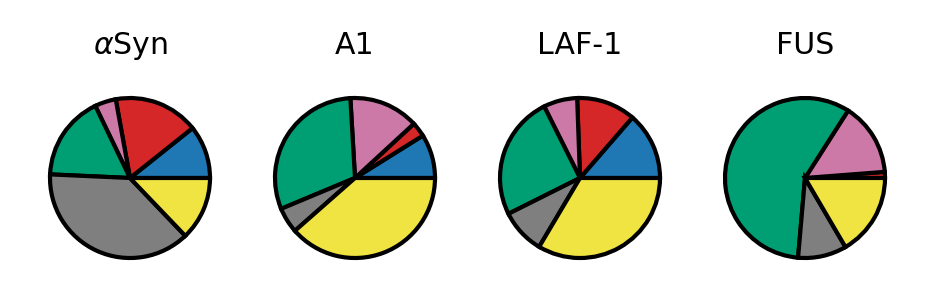

In [37]:
font = {'size': 6}
plt.rc('font', **font)
fig, axs = plt.subplots(1,4, figsize=(3,5), dpi=300, layout='constrained')
axs = axs.flatten()

colors=['tab:blue','tab:red','#CC79A7','#009E73','tab:grey','#F0E442']

for i,p in enumerate(['aSyn','A1','LAF1','FUS']):
    sizes=[down[p].fasta[0].count('R')+down[p].fasta[0].count('K'),
           down[p].fasta[0].count('D')+down[p].fasta[0].count('E'),
           down[p].fasta[0].count('Y')+down[p].fasta[0].count('W')+down[p].fasta[0].count('F'),
           down[p].fasta[0].count('S')+down[p].fasta[0].count('T')+down[p].fasta[0].count('N')+down[p].fasta[0].count('Q')+down[p].fasta[0].count('H')+down[p].fasta[0].count('C'),
           down[p].fasta[0].count('A')+down[p].fasta[0].count('V')+down[p].fasta[0].count('I')+down[p].fasta[0].count('L')+down[p].fasta[0].count('M')+down[p].fasta[0].count('P'),
           down[p].fasta[0].count('G')]
    axs[i].pie(sizes,colors=colors,wedgeprops = {"edgecolor" : "k",
                      'linewidth': 1,
                      'antialiased': True})

axs[0].set_title(r'$\alpha$Syn')
axs[1].set_title(r'A1')
axs[2].set_title(r'LAF-1')
axs[3].set_title(r'FUS')

#axs[0].text(-0.25,1.1, 'A', fontsize=9, weight='bold', transform=axs[0].transAxes)

plt.savefig('fig2a.pdf', dpi=300)

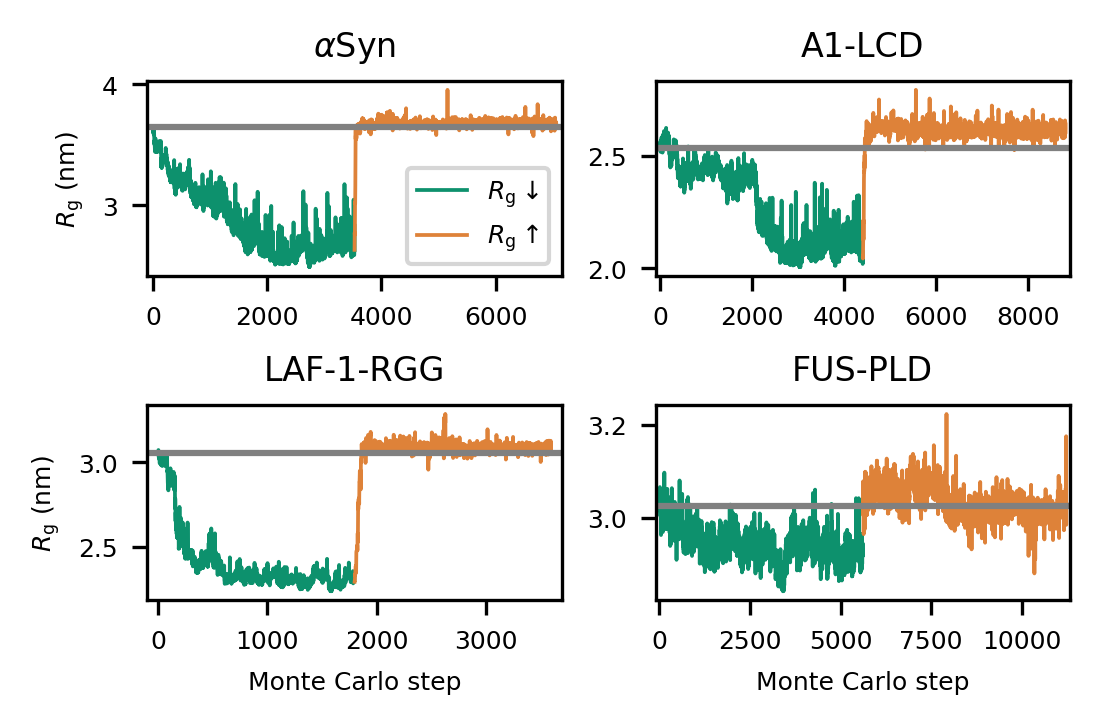

In [38]:
font = {'size': 6}
plt.rc('font', **font)
fig, axs = plt.subplots(2,2, figsize=(3.55,2.3), dpi=300, layout='constrained')
axs = axs.flatten()

for i,p in enumerate(['aSyn','A1','LAF1','FUS']):
    d = down[p].obs.values
    u = up[p].obs.values[:len(d)]
    axs[i].plot(d, label=r'$R_{\rm g} \downarrow$', color='#0D916D', lw=.9)
    axs[i].plot(np.arange(len(d)+1,len(d)+len(u)+1), u, label=r'$R_{\rm g} \uparrow$', color='#DE8239', lw=.9)
    axs[i].hlines(down[p].obs.values[0],-100,len(d)+len(u)+100,color='0.5')
    axs[i].set_xlim(-100,len(d)+len(u)+100)
    axs[i].set_title(labels[i],fontsize=8)

axs[0].set_ylabel(r'$R_{\rm g}$ (nm)')
axs[2].set_ylabel(r'$R_{\rm g}$ (nm)')
axs[2].set_xlabel(r'Monte Carlo step')
axs[3].set_xlabel(r'Monte Carlo step')

axs[0].legend(fontsize=6)
plt.savefig('fig2b.pdf', dpi=300)

### Figure 3

In [19]:
k_down = {}
for p in down.keys()[:-1]:
    k_down[p] = []
    for s in down[p].fasta:
        k_down[p].append(get_kappa(''.join(s)))

In [16]:
nmc = {}
for p in down.keys()[:-1]:
    nmc[p] =  nmc_charge(down[p].fasta.values)

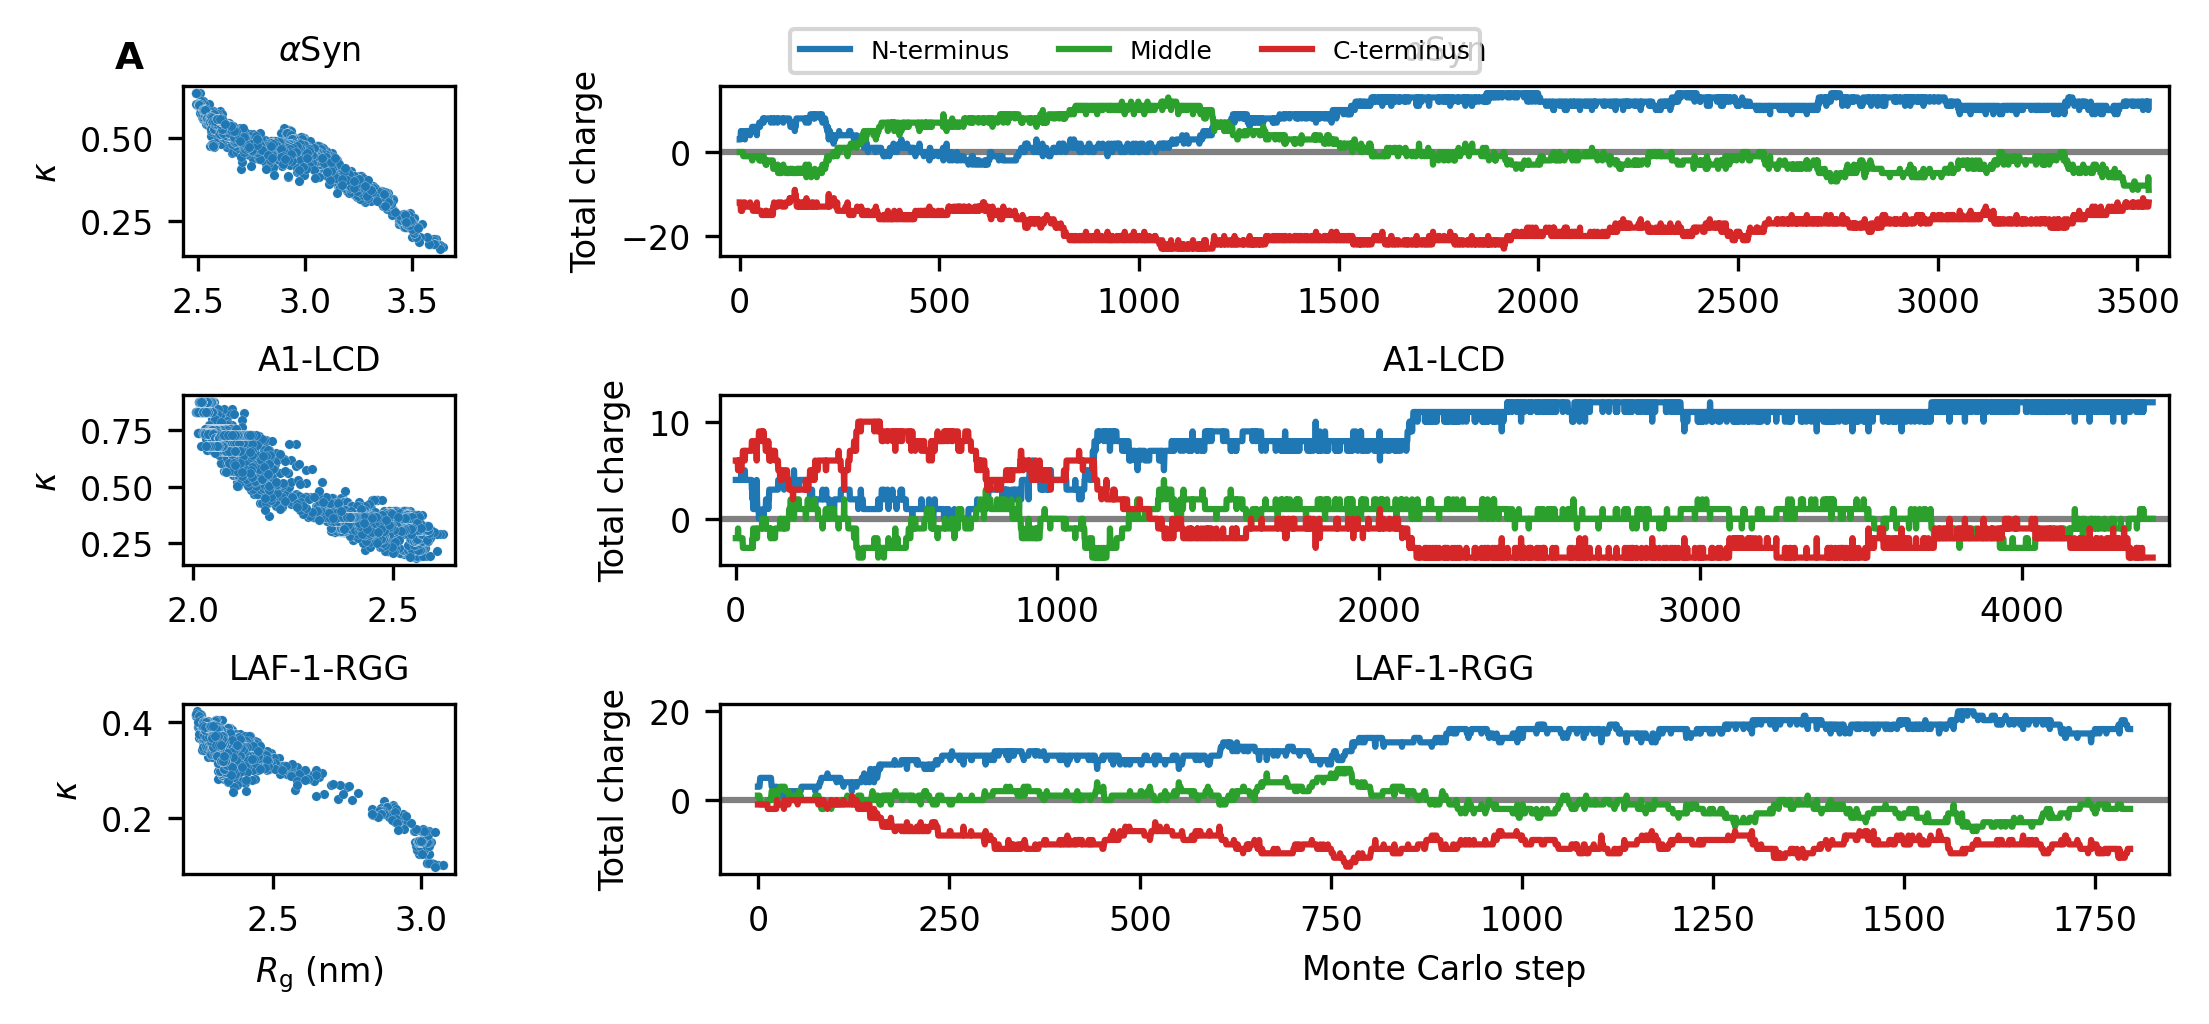

In [29]:
font = {'size': 8}
plt.rc('font', **font)
fig = plt.figure(figsize=(7.25,3.3), dpi=300, layout='constrained')
gs = GridSpec(nrows=3, ncols=20, figure=fig)

ax1 = fig.add_subplot(gs[0:1, 0:3])
ax2 = fig.add_subplot(gs[1:2, 0:3])
ax3 = fig.add_subplot(gs[2:3, 0:3])
ax4 = fig.add_subplot(gs[0:1, 4:20])
ax5 = fig.add_subplot(gs[1:2, 4:20])
ax6 = fig.add_subplot(gs[2:3, 4:20])

#ax1.plot([1, 0], [0, 1], transform=ax1.transAxes,c='0.7')
ax1.scatter(down['aSyn'].obs.values, k_down['aSyn'], edgecolors='w', linewidths=0.05, s=5)
ax1.set_ylabel(r'$\kappa$')
#ax1.set_xlabel(r'$R_{\rm g}$ (nm)')
ax1.set_title(r'$\alpha$Syn', fontsize=8)
ax1.text(-0.25,1.1, 'A', fontsize=9, weight='bold', transform=ax1.transAxes)

#ax2.plot([1, 0], [0, 1], transform=ax2.transAxes,c='0.7')
ax2.scatter(down['A1'].obs.values, k_down['A1'], edgecolors='w', linewidths=0.05, s=5)
#ax2.set_xlabel(r'$R_{\rm g}$ (nm)')
ax2.set_title(r'A1-LCD', fontsize=8)
ax2.set_ylabel(r'$\kappa$')

#ax3.plot([1, 0], [0, 1], transform=ax3.transAxes,c='0.7')
ax3.scatter(down['LAF1'].obs.values, k_down['LAF1'], edgecolors='w', linewidths=0.05, s=5)
ax3.set_xlabel(r'$R_{\rm g}$ (nm)')
ax3.set_title('LAF-1-RGG', fontsize=8)
ax3.set_ylabel(r'$\kappa$')

ax4.hlines(0,-50,len(down['aSyn'].index)+50,color='0.5')
ax4.set_xlim(-50,len(down['aSyn'].index)+50)
ax4.set_title(r'$\alpha$Syn', fontsize=8)
ax4.plot(nmc['aSyn'][...,0], label='N-terminus')
ax4.plot(nmc['aSyn'][...,1], label='Middle', color='tab:green')
ax4.plot(nmc['aSyn'][...,2], label='C-terminus', color='tab:red')
ax4.legend(ncol=3, fontsize=6, bbox_to_anchor=(0.04,1,0,0))
ax4.set_ylabel('Total charge')
#ax1.text(-0.25,-0.65, 'b', fontsize=15, weight='bold', transform=ax1.transAxes)

ax5.hlines(0,-50,len(down['A1'].index)+50,color='0.5')
ax5.set_xlim(-50,len(down['A1'].index)+50)
ax5.set_title('A1-LCD', fontsize=8)
ax5.plot(nmc['A1'][...,0])
ax5.plot(nmc['A1'][...,1], color='tab:green')
ax5.plot(nmc['A1'][...,2], color='tab:red')
ax5.set_ylabel('Total charge')

ax6.hlines(0,-50,len(down['LAF1'].index)+50,color='0.5')
ax6.set_xlim(-50,len(down['LAF1'].index)+50)
ax6.set_title('LAF-1-RGG', fontsize=8)
ax6.plot(nmc['LAF1'][...,0])
ax6.plot(nmc['LAF1'][...,1], color='tab:green')
ax6.plot(nmc['LAF1'][...,2], color='tab:red')
ax6.set_xlabel('Monte Carlo step')
ax6.set_ylabel('Total charge')

plt.savefig('fig3.pdf', dpi=300)

### Figure 4

In [25]:
red_df = pd.read_pickle('120centroids_data.pkl')

exp_ndx = ['R0_g0','R3_g2958','R7_g1520','R7_g3164','R6_g203','R2_g844']
exp_name = ['WT','V1','V2','V3','V4','V5']

rgexp = red_df.loc[exp_ndx].rg.values
csatexp = red_df.loc[exp_ndx].csat_av.values
scdexp = red_df.loc[exp_ndx].SCD
oaroexp = red_df.loc[exp_ndx].o_aro
kappaexp = red_df.loc[exp_ndx].kappa

<ipython-input-28-f57c78208883>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax1.scatter(rgexp[0],kappaexp[0],facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
<ipython-input-28-f57c78208883>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  txt = ax1.annotate(exp_name[i], (rgexp[i], kappaexp[i]), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
<ipython-input-28-f57c78208883>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

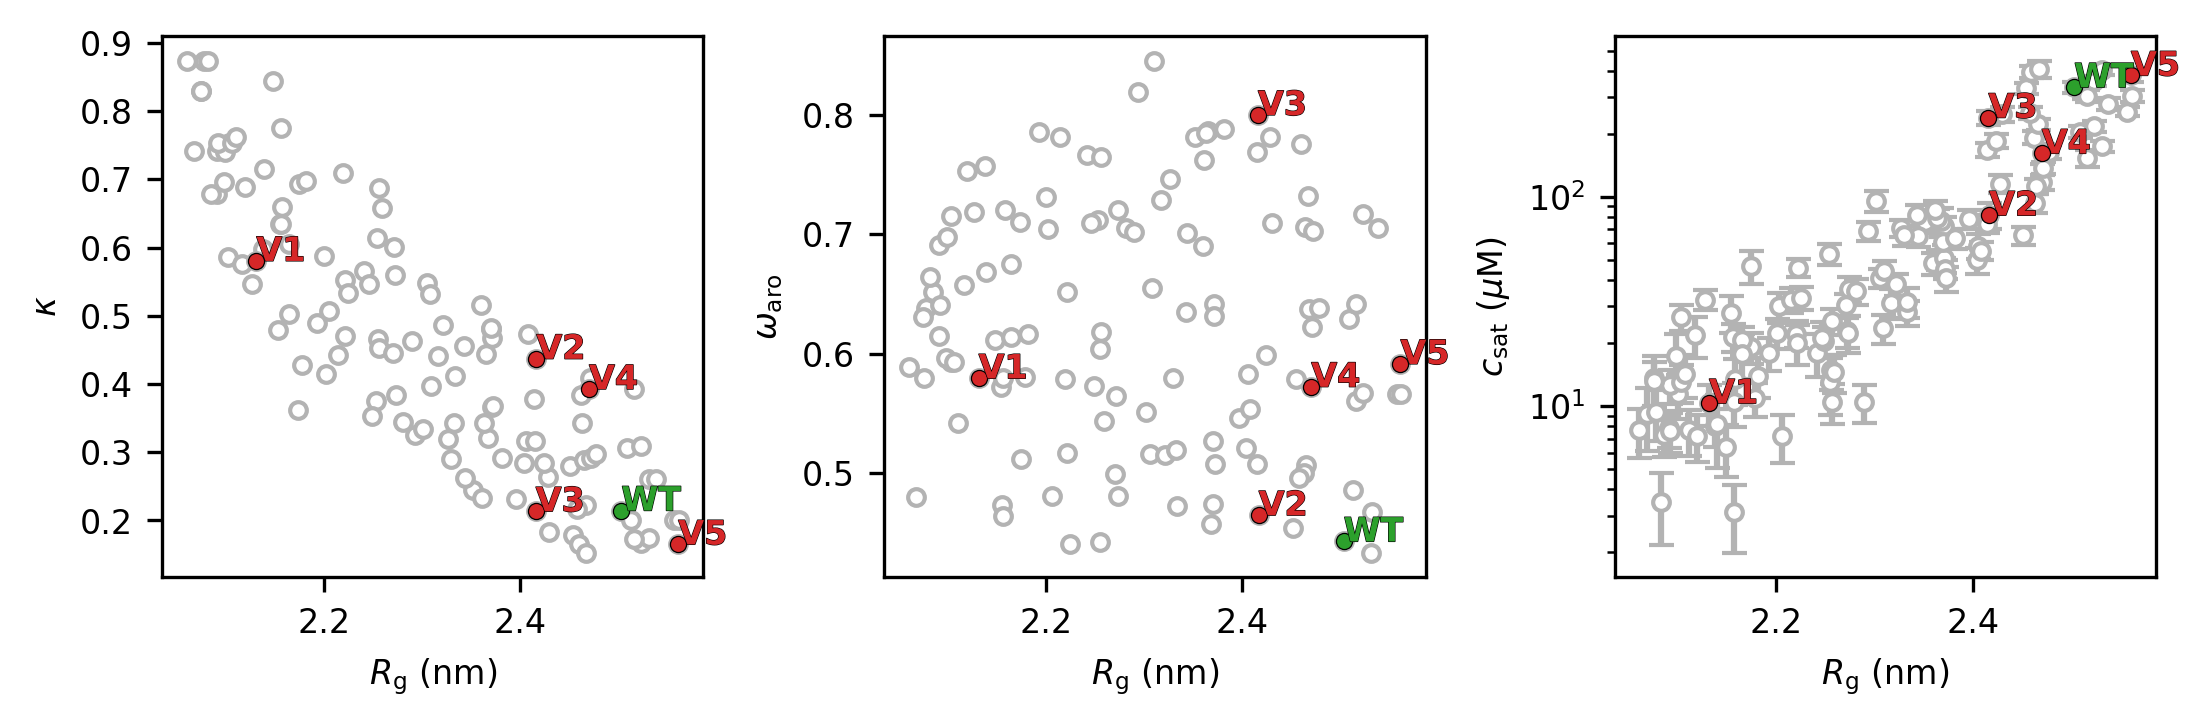

In [28]:
font = {'size': 8}
plt.rc('font', **font)
fig,[ax1,ax2,ax3] = plt.subplots(1,3, figsize=(7.25,3), dpi=300, layout='constrained')

ax1.errorbar(red_df.rg,red_df.kappa, c='0.7', ecolor='0.7', fmt='o', mfc='w', ls='', markersize=4)
ax1.set_ylabel(r'$\kappa$')
ax1.set_xlabel(r'$R_{\rm g}$ (nm)')
ax1.set_box_aspect(1)
ax1.scatter(rgexp[0],kappaexp[0],facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
ax1.scatter(rgexp[1:],kappaexp[1:],facecolor='tab:red',edgecolor='k',s=15,lw=0.3,zorder=500000)
for i,n in enumerate(exp_ndx):
    if exp_name[i] == 'WT':
        txt = ax1.annotate(exp_name[i], (rgexp[i], kappaexp[i]), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
    else:
        txt = ax1.annotate(exp_name[i], (rgexp[i], kappaexp[i]), fontsize=8, zorder=100000000, color='tab:red', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])

ax2.errorbar(red_df.rg, red_df.o_aro, c='0.7', ecolor='0.7', fmt='o', mfc='w', ls='', markersize=4)
ax2.set_xlabel(r'$R_{\rm g}$ (nm)')
ax2.set_ylabel(r'$\omega_{\rm aro}$')
ax2.set_box_aspect(1)
ax2.scatter(rgexp[0],oaroexp[0],facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
ax2.scatter(rgexp[1:],oaroexp[1:],facecolor='tab:red',edgecolor='k',s=15,lw=0.3,zorder=500000)
for i,n in enumerate(exp_ndx):
    if exp_name[i] == 'WT':
        txt = ax2.annotate(exp_name[i], (rgexp[i], oaroexp[i]), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
    else:
        txt = ax2.annotate(exp_name[i], (rgexp[i], oaroexp[i]), fontsize=8, zorder=100000000, color='tab:red', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
        
_, caps, bars = ax3.errorbar(red_df.rg, red_df.csat_av*1000, yerr=red_df.csat_err*1000, c='0.7', ecolor='0.7', fmt='o', mfc='w', ls='', markersize=4, capsize=3)
#[bar.set_alpha(0.7) for bar in bars]
#[cap.set_alpha(0.7) for cap in caps]
ax3.set_box_aspect(1)
ax3.set_yscale('log')
ax3.set_ylabel(r'$c_{\rm sat}$ ($\mu$M)')
ax3.set_xlabel(r'$R_{\rm g}$ (nm)')
ax3.scatter(rgexp[0],csatexp[0]*1000,facecolor='tab:green',edgecolor='k',s=15,lw=0.3,zorder=500000)
ax3.scatter(rgexp[1:],csatexp[1:]*1000,facecolor='tab:red',edgecolor='k',s=15,lw=0.3,zorder=500000)
for i,n in enumerate(exp_ndx):
    if exp_name[i] == 'WT':
        txt = ax3.annotate(exp_name[i], (rgexp[i], csatexp[i]*1000), fontsize=8, zorder=100000000, color='tab:green', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])
    else:
        txt = ax3.annotate(exp_name[i], (rgexp[i], csatexp[i]*1000), fontsize=8, color='tab:red', weight='bold')
        txt.set_path_effects([PathEffects.withStroke(linewidth=0.3, foreground='k')])

plt.savefig('fig4.pdf', dpi=300)

### Figure 5

In [42]:
df = pd.DataFrame()
for i in range(10):
    _ = pd.read_pickle('A1/DOWN/R{}_evo.pkl'.format(i))
    _['ind'] = ['R'+str(i)+'_g'+str(c) for c in _.index]
    df = pd.concat([df,_])
df = df.set_index('ind')

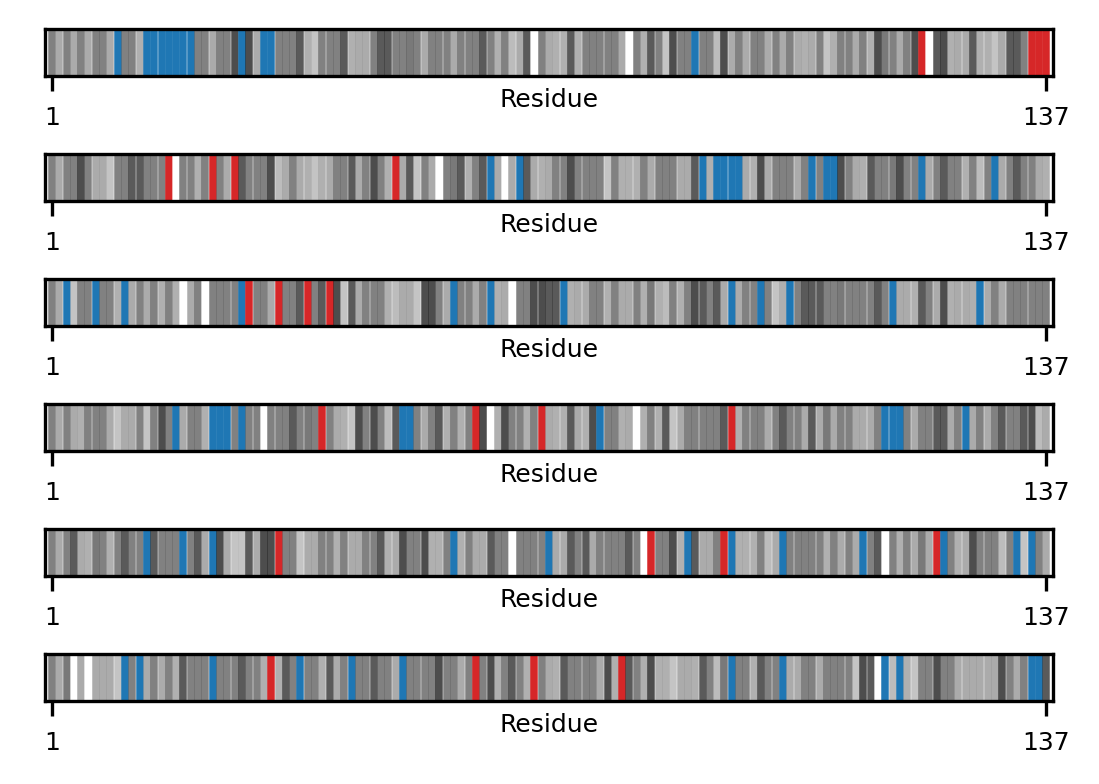

In [50]:
fig,axs = plt.subplots(6,1,figsize=(3.55,2.5), dpi=300, layout='constrained')
axs = axs.flatten()

for ndx,v,ax in zip(['R3_g2958','R7_g1520','R7_g3164','R6_g203','R2_g844','R0_g0'],['V1','V2','V3','V4','V5','WT'],axs):
    seq = 'GS'+''.join(df.loc[ndx].fasta)
    seq_diagram(seq,ax,lw=1.8)
    
plt.savefig('fig5a.pdf', dpi=300)

In [ ]:
name = ['V1','V2','V3','V4','V5','WT']
csat_exp = [14.93,39.09,137.48,101.44,152.33,182.61]
csat_exp_std = [0.57,2.88,7.06,4.39,8.08,1.66]
csat_rep = {
    'V1' : [],
    'V2' : [],
    'V3' : [],
    'V4' : [],
    'V5' : [],
    'WT' : []
}
for rep in ['REP1','REP2','REP3']:
    for i in name:
        av,err,_,_ = Csat(f'EXP_CONSTRUCTS/SLAB/{rep}/{i}.npy',open('EXP_CONSTRUCTS/V4.fasta').readlines()[1].strip(),L=15.,nskip=2000)
        csat_rep[i].append(np.array([av,err]))
csat_calc = [np.array(csat_rep[x])[...,0].mean() for x in name]
csat_calc_std = [np.sqrt((np.array(csat_rep[x])[...,1]**2).sum())/3 for x in name]

rg_saxs = np.array([np.nan,2.37,2.42,2.50,2.59,2.51])
rg_saxs_err = np.array([np.nan,0.018,0.018,0.014,0.011,0.017])
rg_calc = np.array([np.nan,2.42,2.47,2.53,2.62,2.56])
rg_albatross = np.array([np.nan,25.807,24.665,25.900,25.063,25.001])/10

nu_saxs = np.array([np.nan,0.391,0.408,0.428,0.443,0.412])
nu_saxs_err = np.array([np.nan,0.006,0.007,0.006,0.005,0.006])
nu_albatross = np.array([np.nan,0.431,0.423,0.409,0.438,0.437])
nu_svr = np.array([np.nan,0.433,0.470,0.456,0.478,0.474])
nu_calvados = np.array([np.nan,0.376,0.442,0.435,0.454,0.449])

rh_nmr = np.array([2.169,np.nan,np.nan,np.nan,np.nan,2.417])*1.07
rh_nmr_err = np.array([0.096,np.nan,np.nan,np.nan,np.nan,0.074])
rh_nmr_err = np.sqrt(((rh_nmr_err/0.212)/(rh_nmr/0.212))**2 + (0.004/0.227)**2)*rh_nmr
rh_calc = np.array([2.48,np.nan,np.nan,np.nan,np.nan,2.73])

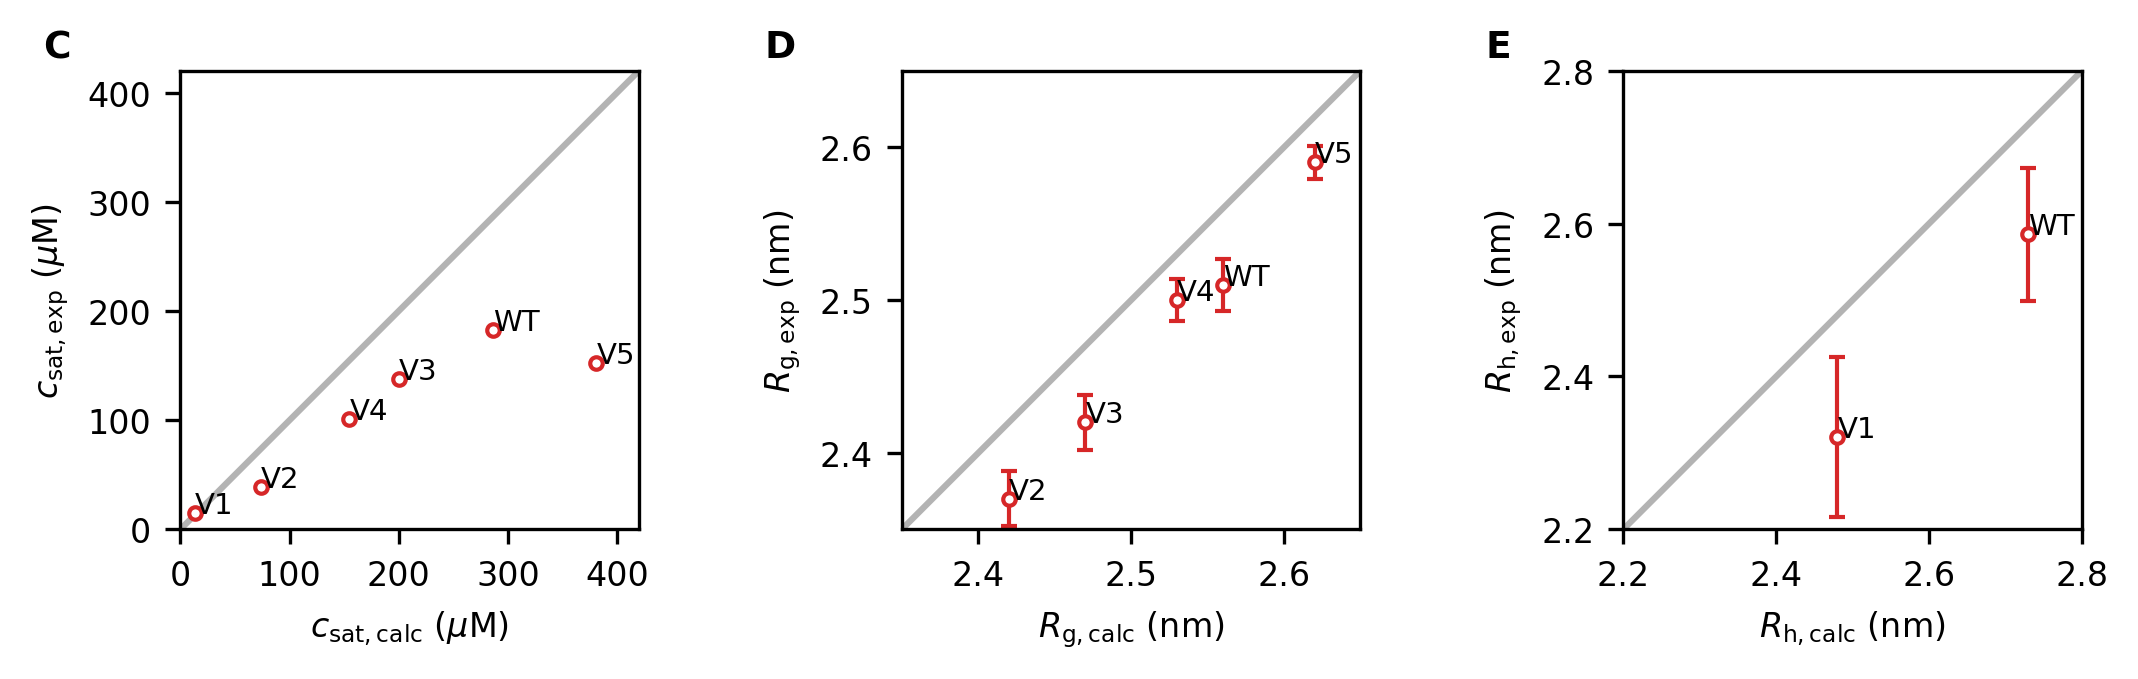

In [59]:
font = {'size': 8}
plt.rc('font', **font)
fig, [ax8,ax9,ax10] = plt.subplots(1,3,figsize=(7.25,2.15), dpi=300, layout='constrained',facecolor='w')

ax8.plot([0, 1], [0, 1], transform=ax8.transAxes,c='0.7')
ax8.errorbar(csat_calc,csat_exp,marker='o', ls='',markersize=3, elinewidth=1,mfc='w',capsize=2,color='tab:red')
ax8.set_xlim(0,420)
ax8.set_ylim(0,420)
for i,n in enumerate(name):
    ax8.annotate(name[i], (csat_calc[i], csat_exp[i]), fontsize=7, zorder=100000000)
ax8.set_xlabel(r'$c_{\rm sat,calc}$ ($\mu$M)')
ax8.set_ylabel(r'$c_{\rm sat,exp}$ ($\mu$M)')
ax8.set_box_aspect(1)
ax8.set_xticks([0,100,200,300,400])

ax9.plot([0, 1], [0, 1], transform=ax9.transAxes,c='0.7')
ax9.errorbar(rg_calc,rg_saxs,rg_saxs_err,marker='o', ls='',markersize=3, elinewidth=1,mfc='w',capsize=2, color='tab:red')
ax9.set_xlim(2.35,2.65)
ax9.set_ylim(2.35,2.65)
for i,n in enumerate(name):
    ax9.annotate(name[i], (rg_calc[i], rg_saxs[i]), fontsize=7, zorder=100000000)
ax9.set_xlabel(r'$R_{\rm g,calc}$ (nm)')
ax9.set_ylabel(r'$R_{\rm g,exp}$ (nm)')
ax9.set_box_aspect(1)
ax9.set_yticks([2.4,2.5,2.6])

ax10.plot([0, 1], [0, 1], transform=ax10.transAxes,c='0.7')
ax10.errorbar(rh_calc,rh_nmr,rh_nmr_err,marker='o', ls='',markersize=3, elinewidth=1,mfc='w',capsize=2, color='tab:red')
ax10.set_xlim(2.2,2.8)
ax10.set_ylim(2.2,2.8)
ax10.set_box_aspect(1)
ax10.set_xlabel(r'$R_{\rm h,calc}$ (nm)')
ax10.set_ylabel(r'$R_{\rm h,exp}$ (nm)')
for i,n in enumerate(name):
    ax10.annotate(name[i], (rh_calc[i], rh_nmr[i]), fontsize=7, zorder=100000000)
ax10.set_yticks([2.2,2.4,2.6,2.8])

ax8.text(-0.3,1.03, 'C', fontsize=9, weight='bold', transform=ax8.transAxes)
ax9.text(-0.3,1.03, 'D', fontsize=9, weight='bold', transform=ax9.transAxes)
ax10.text(-0.3,1.03, 'E', fontsize=9, weight='bold', transform=ax10.transAxes)

plt.savefig('fig5cde.pdf', dpi=300)

### Figure 6

In [63]:
cmap_evo = pd.read_pickle('V1_CMAP/evolution_cmap.pkl')
evo_mse = cmap_evo.obs.values

cmap_evo_filt = cmap_evo.loc[cmap_evo.index.values[ np.where( cmap_evo.simulate == True ) ]]
min_ind = cmap_evo_filt.index[cmap_evo_filt.obs.argmin()]
print (cmap_evo.loc[min_ind])

fasta       [S, G, G, G, G, S, Y, G, S, S, S, R, R, K, R, ...
obs                                                  1.423294
simulate                                                 True
mc                                                       True
mc_cp                                                0.043918
Name: 3117, dtype: object


In [64]:
pairs = np.loadtxt('V1_CMAP/pairs.dat')
target_cmap = np.loadtxt('V1_cmap.dat')

a1_cmap = np.loadtxt('g0_cmap.dat')
min_cmap = np.loadtxt(f'V1_CMAP/g{min_ind}_cmap.dat')

vmin = np.min([np.min(np.log(target_cmap)),np.min(np.log(a1_cmap)),np.min(np.log(min_cmap))])

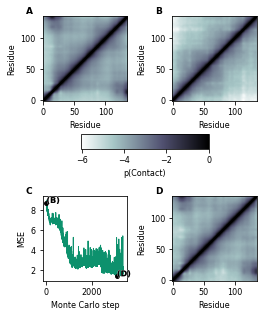

In [65]:
font = {'size': 8}
plt.rc('font', **font)
fig,axs = plt.subplots(2,2, figsize=(3.55,5),layout='constrained')
axs = axs.flatten()

plot_cmap(np.log(target_cmap),pairs,axs[0],vmin=vmin,vmax=0)

plot_cmap(np.log(a1_cmap),pairs,axs[1],vmin=vmin,vmax=0)

axs[2].plot(evo_mse[np.where(evo_mse != False)],lw=1,c='#0D916D')
axs[2].set_xlabel('Monte Carlo step')
axs[2].set_ylabel('MSE')
axs[2].set_box_aspect(1)
axs[2].scatter([0,min_ind],[cmap_evo.loc[0].obs, cmap_evo.loc[min_ind].obs],color='k',zorder=10,s=15)
txt = axs[2].annotate('(B)', (0, cmap_evo.loc[0].obs), fontsize=8, zorder=100000000, color='k', weight='bold')
txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='w')])
txt = axs[2].annotate('(D)', (min_ind, cmap_evo.loc[min_ind].obs), fontsize=8, zorder=100000000, color='k', weight='bold')
txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='w')])

im = plot_cmap(np.log(min_cmap),pairs,axs[3],vmin=vmin,vmax=0)

axs[0].text(-0.2,1.03, 'A', fontsize=9, weight='bold', transform=axs[0].transAxes)
axs[1].text(-0.2,1.03, 'B', fontsize=9, weight='bold', transform=axs[1].transAxes)
axs[2].text(-0.2,1.03, 'C', fontsize=9, weight='bold', transform=axs[2].transAxes)
axs[3].text(-0.2,1.03, 'D', fontsize=9, weight='bold', transform=axs[3].transAxes)

cbar_ax = fig.add_axes([0.3, 0.5, 0.5, 0.04])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='p(Contact)')

plt.savefig('fig6.pdf', dpi=300)

### Figure 7

In [66]:
idrome = pd.read_csv('IDRome_DB.csv', index_col=0)
nupred = pd.read_csv('nupred.csv',index_col='name')
idrome_nardini = pd.read_csv('IDRome_NARDINI_025_1e5.csv', index_col=0)
idrome_noZ0 = idrome_nardini[idrome_nardini['z_delta_+-'] != 0]

In [72]:
clustered_seq = ['A0A1B0GTS1_188_333','O75474_1_169','Q9UHJ3_629_790']
form_name = ['HSFX4','FRAT2','SFMBT1']

In [70]:
xy = np.vstack([idrome_noZ0['nu'].values,idrome_noZ0['z_delta_+-'].values])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
nu, zscore, dens = idrome_noZ0['nu'].values[idx], idrome_noZ0['z_delta_+-'].values[idx], z[idx]
z = np.log(dens)
z = (z+abs(z.min()))/z.max()

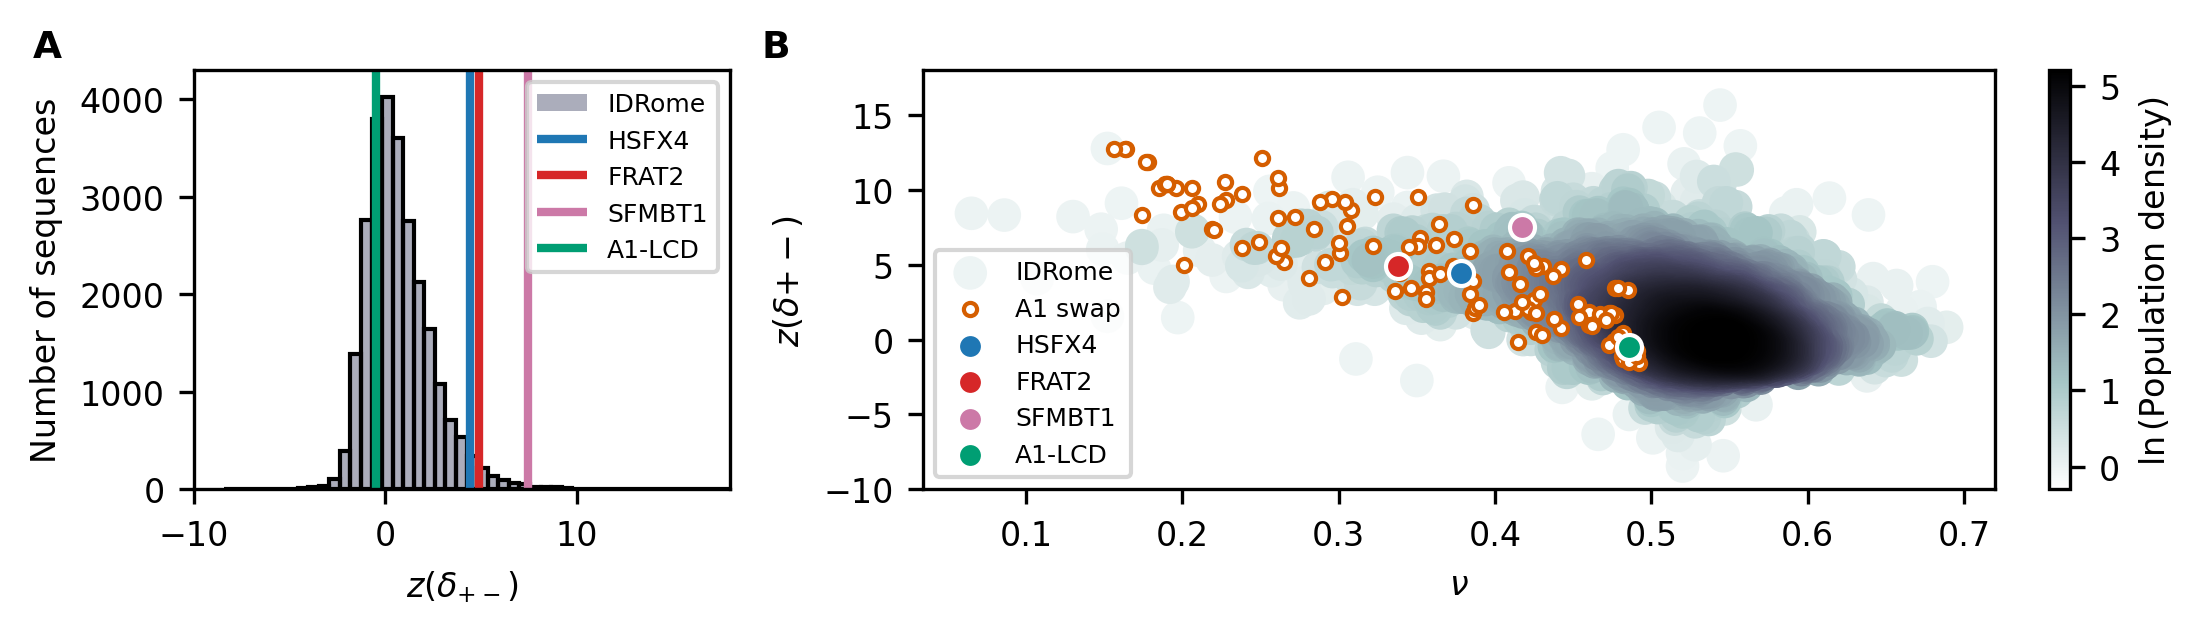

In [75]:
font = {'size': 8}
plt.rc('font', **font)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7.25,2), gridspec_kw={'width_ratios': [1, 2]}, dpi=300, layout='constrained',facecolor='w')

ax0.hist(idrome_noZ0['z_delta_+-'],bins=50,color="#595C79",alpha=0.5,label='IDRome')
ax0.hist(idrome_noZ0['z_delta_+-'],bins=50,edgecolor="k",facecolor="None",lw=1)
for i,x in enumerate(clustered_seq):
    ax0.vlines(idrome_noZ0['z_delta_+-'].loc[x],0,4300,color=colors[i],lw=2,label=form_name[i])
ax0.vlines(nupred['zscore'].loc['R0_g0'],0,4300,lw=2,color=colors[3],label='A1-LCD')
ax0.set_xlim(-10,18)
ax0.set_ylim(0,4300)
ax0.set_xlabel(r'$z(\delta_{+-})$')
ax0.set_ylabel(r'Number of sequences')
ax0.legend(fontsize=6)

pcm = ax1.scatter(nu, zscore, c=z, s=50, cmap=plt.cm.get_cmap('bone_r'),vmin=-0.3,label='IDRome')
ax1.scatter(nupred.nu,nupred.zscore,edgecolor='#D55E00',facecolor='w',s=10,label='A1 swap')
fig.colorbar(pcm, ax=ax1,label=r'$\ln$(Population density)')
ax1.set_ylim(-10,18)
for i,x in enumerate(clustered_seq):
    ax1.scatter(idrome_noZ0['nu'].loc[x],idrome_noZ0['z_delta_+-'].loc[x],color=colors[i],label=form_name[i],edgecolor='w')
ax1.scatter(nupred['nu'].loc['R0_g0'],nupred['zscore'].loc['R0_g0'],color=colors[3],label='A1-LCD',edgecolor='w')
ax1.legend(fontsize=6)
ax1.set_xlabel(r'$\nu$')
ax1.set_ylabel(r'$z(\delta{+-})$')

ax0.text(-0.3,1.03, 'A', fontsize=9, weight='bold', transform=ax0.transAxes)
ax1.text(-0.15,1.03, 'B', fontsize=9, weight='bold', transform=ax1.transAxes)

plt.savefig('fig7ab.pdf', dpi=300)

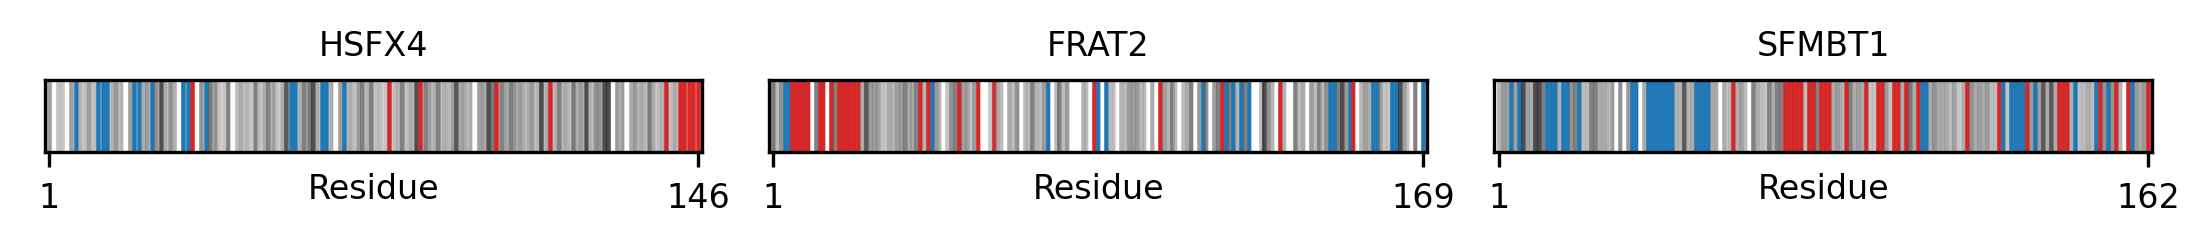

In [85]:
fig, axs = plt.subplots(1,3,figsize=(7.25,0.7), dpi=300, layout='constrained',facecolor='w')
axs = axs.flatten()

for ndx,ax,n in zip(clustered_seq,axs,form_name):
    seq = idrome.loc[ndx].fasta
    seq_diagram(seq,ax,lw=1.1)
    ax.set_title(n,fontsize=8)
    
plt.savefig('fig7c.pdf', dpi=300)

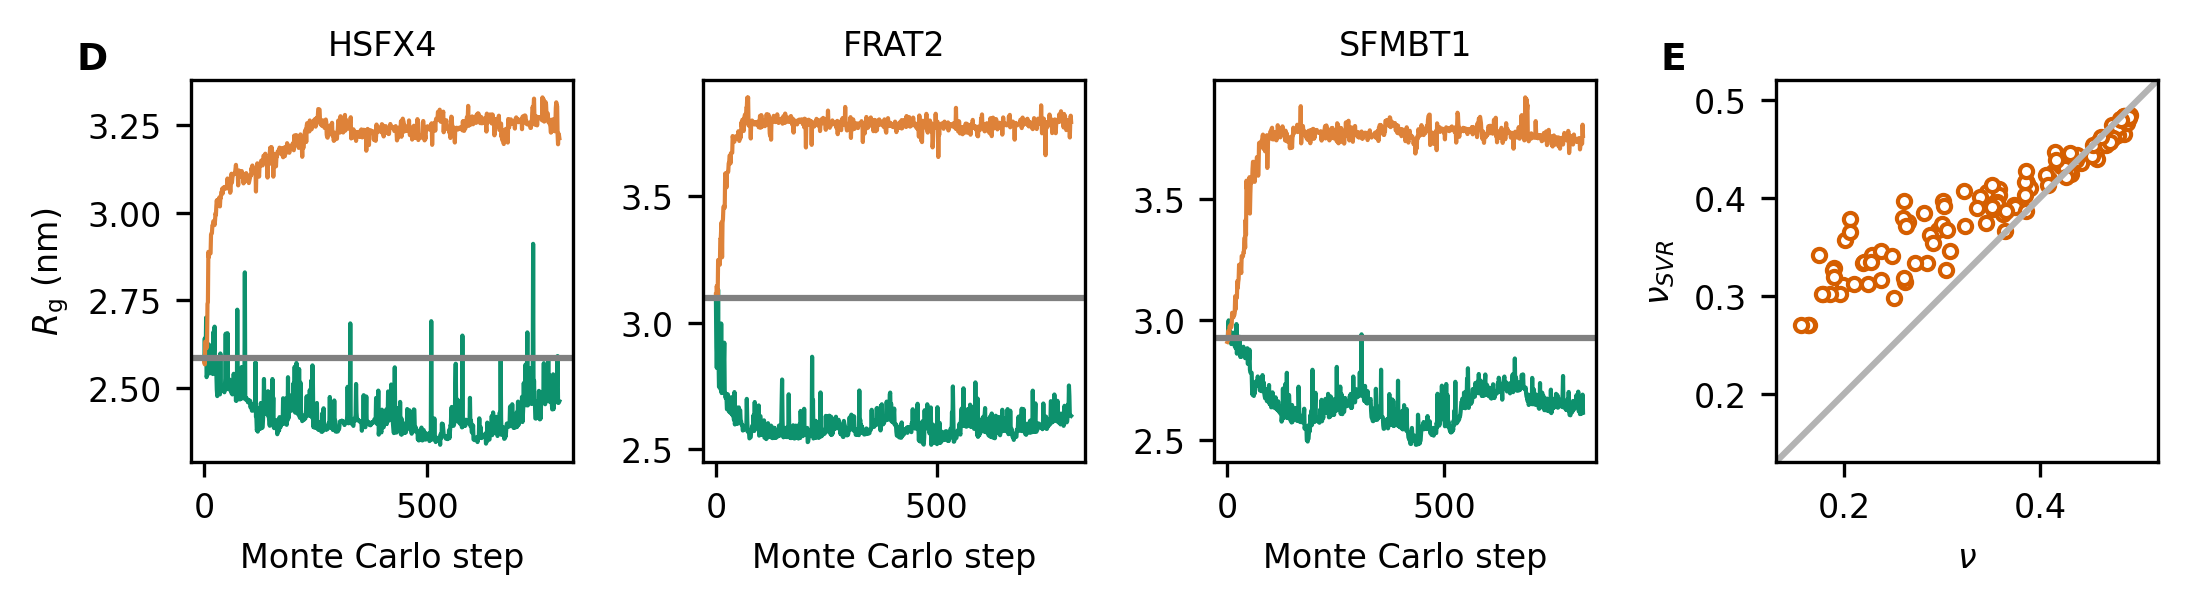

In [86]:
fig, axs = plt.subplots(1,4,figsize=(7.25,1.9), dpi=300, layout='constrained',facecolor='w')
axs = axs.flatten()

for ax,ndx,n in zip(axs[:-1],clustered_seq,['HSFX4','FRAT2','SFMBT1']):
    ax.plot(pd.read_pickle(f'{ndx}_down.pkl').obs.values,lw=1,label=r'$R_g \downarrow$',color='#0D916D')
    ax.plot(pd.read_pickle(f'{ndx}_up.pkl').obs.values[:len(pd.read_pickle(f'{ndx}_down.pkl').obs.values)],label=r'$R_g \uparrow$', color='#DE8239', lw=1)
    ax.hlines(pd.read_pickle(f'{ndx}_down.pkl').obs.values[0],-30,len(pd.read_pickle(f'{ndx}_down.pkl').obs.values)+30,color='0.5')
    ax.set_xlim(-30,len(pd.read_pickle(f'{ndx}_down.pkl').obs.values)+30)
    ax.set_title(n,fontsize=8)
    ax.set_box_aspect(1)
    ax.set_xlabel(r'Monte Carlo step')
axs[0].set_ylabel(r'$R_{\rm g}$ (nm)')
#axs[0].legend(fontsize=5)


axs[3].scatter(nupred.nu,nupred.nu_svr,edgecolor='#D55E00',facecolor='w',s=10)
axs[3].set_xlabel(r'$\nu$')
axs[3].set_ylabel(r'$\nu_{SVR}$')
axs[3].set_box_aspect(1)
axs[3].plot([0, 1], [0, 1], transform=axs[3].transAxes,c='0.7')
axs[3].set_xlim(0.13,0.52)
axs[3].set_ylim(0.13,0.52)

axs[0].text(-0.3,1.03, 'D', fontsize=9, weight='bold', transform=axs[0].transAxes)
axs[3].text(-0.3,1.03, 'E', fontsize=9, weight='bold', transform=axs[3].transAxes)

plt.savefig('fig7de.pdf',dpi=300)